# Importing Necessary Packages

In [6]:
import operator as op
import numpy as np
import pandas as pd
import requests
import param 
import panel as pn
import hvplot.pandas
import hvplot.streamz
import holoviews as hv
from holoviews.element.tiles import EsriImagery 
from holoviews.selection import link_selections
from datashader.utils import lnglat_to_meters
from streamz.dataframe import PeriodicDataFrame

In [7]:
openweathermap_api_key='4adabbbbdfa3c4a90003b2a12ed9da2f'

In [8]:
def weather_data( cities, openweathermap_api_key=openweathermap_api_key):
    """Get weather data for some cities using the open_weather_map_api  """
    list=[]
    for c in cities:
         res = requests.get(f'http://api.openweathermap.org/data/2.5/weather?q={c}&appid={openweathermap_api_key}&units=imperial')
         list.append(res.json())
         
        
    df=pd.DataFrame(list)
    df['lon']=df['coord'].map(op.itemgetter('lon'))
    df['lat']=df['coord'].map(op.itemgetter('lat'))
    df['Temprature']=df['main'].map(op.itemgetter('temp'))
    df['Humidity']=df['main'].map(op.itemgetter('humidity'))
    df['Wind_Speed']=df['wind'].map(op.itemgetter('speed'))
   
    return df[['name','lon','lat','Temprature','Humidity','Wind_Speed']]


In [9]:
def streaming_weather_data(**kwargs):
    """Function get weather of Dhaka"""
    df=weather_data(['Dhaka'])
    df['time']=[pd.Timestamp.now()]
    return df.set_index('time')
# A streaming Data_Frame
df=PeriodicDataFrame(streaming_weather_data,interval='30s')

pn_realtime=pn.Column
(
    pn.Row(
    df[['Temprature']].hvplot.line(title='Temprature',backlog=1000),
    df[['Humidity']].hvplot.line(title='Humidity',backlog=1000),
    df[['Wind_Speed']].hvplot.line(title='Wind Speed',backlog=1000)
    )
    
    
)

Row
    [0] HoloViews(DynamicMap)
    [1] HoloViews(DynamicMap)
    [2] HoloViews(DynamicMap)

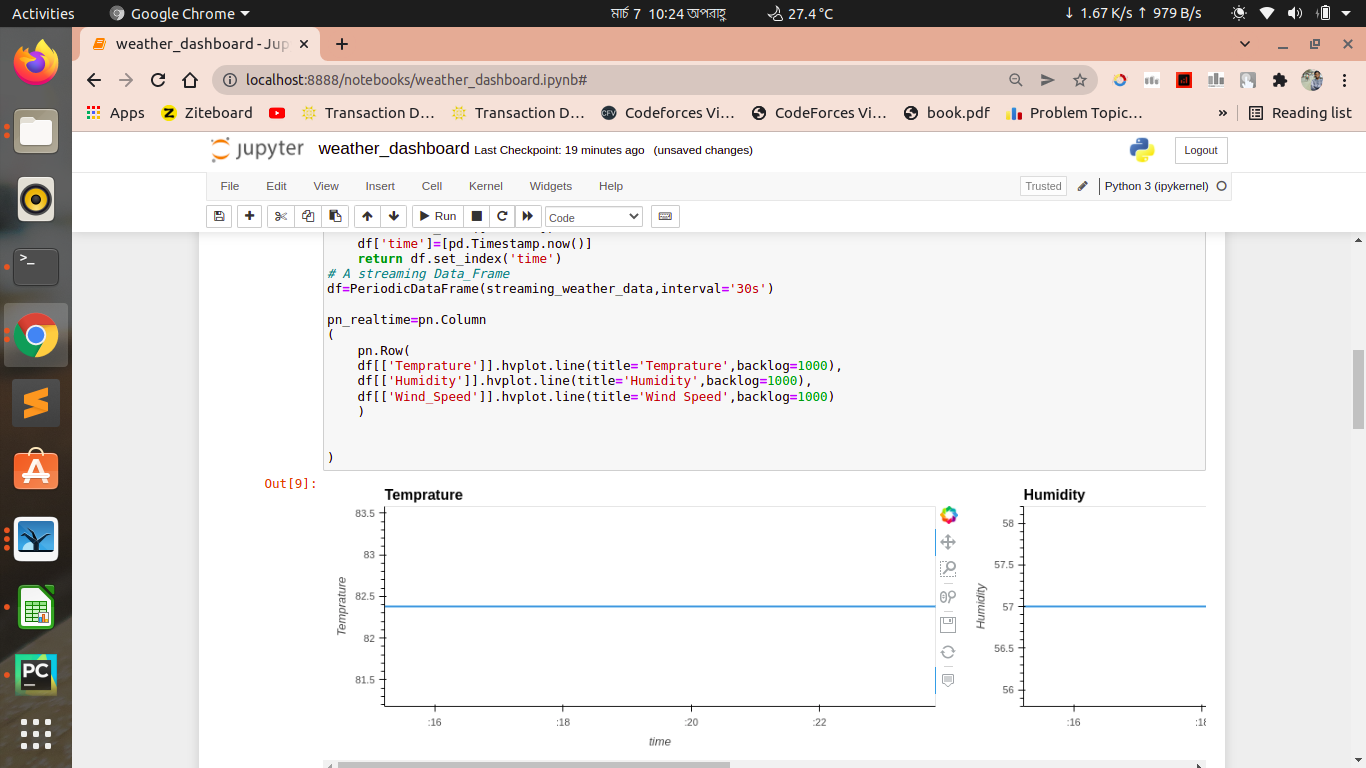

In [16]:
from IPython.display import Image
PATH = "/home/keai33/Pictures/"
Image(filename = PATH + "Screenshot from 2022-03-07 22-24-12.png", width=1080, height=720)

In [10]:
cities=['Dhaka','Chittagong','Kolkata']
def weather_plot(col,cities=cities):
    """Ploting weather data"""
    df=weather_data(cities)
    df['x'],df['y']=lnglat_to_meters(df['lon'],df['lat'])
    table=hv.Table(df[['name',col]]).opts(width=800)
    points=df.hvplot.scatter('x','y',c=col,cmap='bkr',hover_cols=['name'])
    map_tiles=EsriImagery().opts(alpha=0.5,width=900,height=480,bgcolor='white')
    return pn.Column(points * map_tiles,table)


In [11]:

class refresh_weather_dashboard(param.Parameterized):
    action = param.Action(lambda x: x.param.trigger('action'), label='Refresh')
    select_column = param.ObjectSelector(default='Temprature', objects=['Temprature', 'Humidity', 'Wind_Speed'])

       
    @param.depends('action', 'select_column')
    def get_plot(self):
        return weather_plot(self.select_column)

    
weather_dashboard = refresh_weather_dashboard()

pn_weather = pn.Column(
       pn.panel(weather_dashboard.param, show_labels=True, show_name=False, margin=0),
       weather_dashboard.get_plot, width=400
)

In [12]:
pan=pn.Tabs(
('Real Time',pn_realtime),
    ('Refresh weather Dashboard',pn_weather)
).servable()
pan

Tabs
    [0] Column(margin=5, name='Real Time', width=300)
        [0] StaticText(value='<b>Real Time</b>')
        [1] LiteralInput(name='Align', value='start')
        [2] LiteralInput(name='Aspect ratio')
        [3] LiteralInput(name='Background')
        [4] ListInput(name='Css classes', type=<class 'list'>)
        [5] IntInput(name='Width', start=0)
        [6] IntInput(name='Height', start=0)
        [7] IntInput(name='Min width', start=0)
        [8] IntInput(name='Min height', start=0)
        [9] IntInput(name='Max width', start=0)
        [10] IntInput(name='Max height', start=0)
        [11] LiteralInput(name='Margin', value=0)
        [12] Select(name='Width policy', options=OrderedDict([('auto', ...]), value='auto')
        [13] Select(name='Height policy', options=OrderedDict([('auto', ...]), value='auto')
        [14] Select(name='Sizing mode', options=OrderedDict([('fixed', ...]))
        [15] Checkbox(name='Visible', value=True)
        [16] Checkbox(name='Loading')
        [17] ListInput(name='Objects', type=<class 'list'>)
        [18] Checkbox(name='Scroll')
        [19] LiteralInput(name='Row sizing')
    [1] Column(width=400)
        [0] Column(name='refresh_weather_dashboard..., width=300)
            [0] Button(name='Refresh')
            [1] Select(options=OrderedDict([('Temprature'...]), value='Temprature')
        [1] ParamMethod(method)

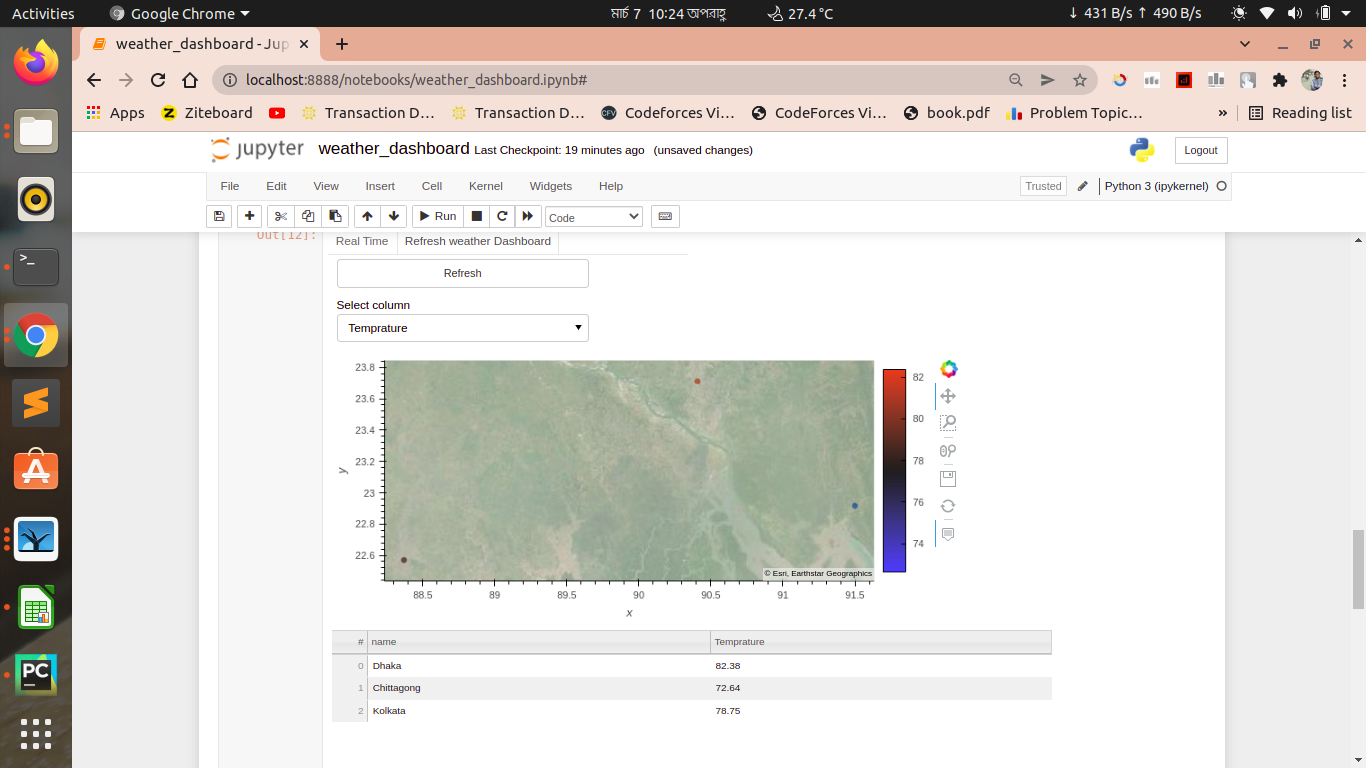

In [17]:
from IPython.display import Image
PATH = "/home/keai33/Pictures/"
Image(filename = PATH + "Screenshot from 2022-03-07 22-24-16.png", width=1080, height=720)